In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader
from torch import cuda
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def set_seed(seed):
    random.seed(seed) 
    np.random.seed(seed)
    torch.manual_seed(seed) 
    if torch.cuda.device_count() > 0: 
        torch.cuda.manual_seed_all(seed)

set_seed(5)

In [5]:
# read full data
df = pd.read_csv('../data/raw/doordash.csv')
df = df[['item_name', 'l1', 'l2']]
df.head()

,item_name,l1,l2
0,E & J Brandy Apple (750 ml),Alcohol,Liquor
1,Fairbanks Cream Sherry California (1.5 L),Alcohol,Liquor
2,Augustine Brandy Premium (1.75 l),Alcohol,Liquor
3,E & J Brandy VS Original (750 ml),Alcohol,Liquor
4,E&J VSOP Brandy (1.75lt),Alcohol,Liquor


In [6]:
(df['l1'] == 'Alcohol') & (df['l1'] == 'Liquor')

0        False
1        False
2        False
3        False
4        False
         ...  
95592    False
95593    False
95594    False
95595    False
95596    False
Name: l1, Length: 95597, dtype: bool

In [7]:
set(df['l1'])

{'Alcohol',
 'Baby',
 'Baby & Child',
 'Bakery',
 'Beauty',
 'Candy',
 'Condiments',
 'Dairy & Eggs',
 'Drinks',
 'Fresh Food',
 'Frozen',
 'Household',
 'Meat & Fish',
 'Medicine',
 'Pantry',
 'Personal Care',
 'Pet Care',
 'Produce',
 'Snacks',
 'Vitamins'}

In [8]:
# Baby & Child has been mislabeled as Baby
df['l1'] = df['l1'].apply(lambda x: "Baby & Child" if str(x) == "Baby" else x)
set(df['l1'])

{'Alcohol',
 'Baby & Child',
 'Bakery',
 'Beauty',
 'Candy',
 'Condiments',
 'Dairy & Eggs',
 'Drinks',
 'Fresh Food',
 'Frozen',
 'Household',
 'Meat & Fish',
 'Medicine',
 'Pantry',
 'Personal Care',
 'Pet Care',
 'Produce',
 'Snacks',
 'Vitamins'}

In [9]:
# encode target variable
class_name_to_id = {} # key: target name, value: target encoding
def encode_target(target):
    if target not in class_name_to_id.keys():
        class_name_to_id[target]=len(class_name_to_id)
    return class_name_to_id[target]

df['l1_target'] = df['l1'].apply(lambda x: encode_target(x))

df.head()

,item_name,l1,l2,l1_target
0,E & J Brandy Apple (750 ml),Alcohol,Liquor,0
1,Fairbanks Cream Sherry California (1.5 L),Alcohol,Liquor,0
2,Augustine Brandy Premium (1.75 l),Alcohol,Liquor,0
3,E & J Brandy VS Original (750 ml),Alcohol,Liquor,0
4,E&J VSOP Brandy (1.75lt),Alcohol,Liquor,0


In [15]:
# given class id, return name
class_id_to_name = {i: name for name, i in class_name_to_id.items()}

In [16]:
l1_set = set(df['l1'])
l1_set

{'Alcohol',
 'Baby & Child',
 'Bakery',
 'Beauty',
 'Candy',
 'Condiments',
 'Dairy & Eggs',
 'Drinks',
 'Fresh Food',
 'Frozen',
 'Household',
 'Meat & Fish',
 'Medicine',
 'Pantry',
 'Personal Care',
 'Pet Care',
 'Produce',
 'Snacks',
 'Vitamins'}

In [17]:
l1_categories_count = len(l1_set)
print("# L1 categories:", l1_categories_count)
print("# Total products: ", len(df))

# L1 categories: 19
# Total products:  95597


In [18]:
df['l1'].value_counts()

Personal Care    19344
Pantry           13594
Household         8037
Snacks            7796
Drinks            7620
Vitamins          5965
Frozen            5482
Alcohol           5233
Dairy & Eggs      4224
Medicine          4050
Candy             3393
Baby & Child      2609
Bakery            2197
Meat & Fish       1708
Produce           1253
Pet Care          1180
Beauty             819
Fresh Food         564
Condiments         529
Name: l1, dtype: int64

In [19]:
# check for missing values
df.isnull().sum()

item_name    4
l1           0
l2           0
l1_target    0
dtype: int64

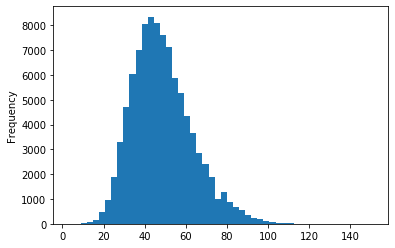

In [20]:
# figure out max length
item_name_lengths = df.item_name.apply(lambda x: len(str(x)))
item_name_lengths.plot.hist(bins=50)

In [21]:
# clean data
def clean(string):
    string = " ".join(string.split())  # standardize whitespace
    string = string.rstrip().lstrip()  # strip left/right whitespace
    return string

cleaned_names = df['item_name'].apply(lambda x: clean(str(x)))

# cleaning stats (obv only works on first run)
print("# of cleaned samples:", (cleaned_names != df['item_name']).sum())

df['item_name'] = cleaned_names

# of cleaned samples: 277


In [126]:
# tokenize/train params
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
MAX_LEN = 100
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [127]:
# test bert tokenization
tokenizer(
    df['item_name'][0],
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True # TODO: measure performance of truncated samples
)

{'input_ids': [101, 142, 111, 147, 12381, 1183, 7302, 113, 9416, 182, 1233, 114, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [128]:
class L1Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        # TODO: batch tokenize 
        inputs = self.tokenizer(
            str(self.data.item_name[index]),
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True # TODO: measure performance of truncated samples
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.l1_target[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [129]:
# Split train/test
train_size = 0.8
train_dataset=df.sample(frac=train_size, random_state=1)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = L1Dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = L1Dataset(test_dataset, tokenizer, MAX_LEN)

TRAIN Dataset: (76478, 4)
TEST Dataset: (19119, 4)


In [27]:
train_size

NameError: name 'train_size' is not defined

In [130]:
# data loaders
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0  # INCREASE for multiprocessing
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [131]:
# Simple dropout + dense layer on top of DistillBERT
class DistillBERTClass(torch.nn.Module):
    def __init__(self, output_size):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, output_size)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [132]:
# get device
assert cuda.is_available()
device = 'cuda'

In [133]:
model = DistillBERTClass(l1_categories_count)
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [134]:
# simple loss, optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

In [135]:
def compute_acc(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [144]:
def train(epoch):
    model.train()
    n_iter = 0
    total_loss, total_correct, total_steps = 0
    for batch_iter, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        
        # predict and compute loss
        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        _, preds = torch.max(outputs.data, dim=1)
        
        # track loss/acc
        total_correct += compute_acc(preds, targets)
        total_loss += loss.item()
        total_steps += targets.size(0)
        if batch_iter % 100 == 0:
            print((f"Epoch: {epoch}, "
                   f"Iter: {n_iter}, "
                   f"Loss: {loss.item() / total_steps}, "
                   f"Accuracy: {(total_correct * 100) / total_steps}"))
            
            # reset stats
            total_loss, total_correct, total_steps = 0
            
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # track iterations
        n_iter += targets.size(0)
    

In [188]:
num_epochs = 1
for epoch in range(num_epochs):
    train(epoch)

Epoch: 0,
                  Iter: 0,
                  Loss: 0.00334918312728405,
                  Accuracy: 100.0
Epoch: 0,
                  Iter: 16000,
                  Loss: 0.004253698512911797,
                  Accuracy: 93.75
Epoch: 0,
                  Iter: 32000,
                  Loss: 0.0024228952825069427,
                  Accuracy: 100.0
Epoch: 0,
                  Iter: 48000,
                  Loss: 0.0011364798992872238,
                  Accuracy: 100.0
Epoch: 0,
                  Iter: 64000,
                  Loss: 0.00272365752607584,
                  Accuracy: 100.0


In [146]:
# validate
model.eval()
preds = []
targets = []
with torch.no_grad():
    for data in tqdm(testing_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        batch_targets = data['targets'].to(device, dtype = torch.long)

        # generate outputs
        outputs = model(ids, mask).squeeze()

        _, batch_preds = torch.max(outputs.data, dim=1)
        preds.extend(batch_preds.tolist())
        targets.extend(batch_targets.tolist())

assert(len(preds) == len(targets))
preds = np.array(preds)
targets = np.array(targets)

100%|██████████| 1195/1195 [00:26<00:00, 44.85it/s]


In [211]:
# breakdown pred accuracy by class
preds = pd.Series(preds)
targets = pd.Series(targets)

# accuracies per class
class_scores = (preds == targets).groupby(targets).mean()

# names per class
class_names = pd.Series([class_id_to_name[i] for i in range(len(class_scores))])

# frequency per class
class_frequencies = df.l1_target.value_counts()

results = pd.DataFrame({"Frequency": list(results["Frequency"]), "Accuracy": list(results["Accuracy"])}, index=list(class_names))
results.sort_values('Frequency', ascending=False)

,Frequency,Accuracy
Personal Care,19344,0.968351
Pantry,13594,0.929073
Household,8037,0.955272
Snacks,7796,0.914135
Drinks,7620,0.948520
Vitamins,5965,0.919156
Frozen,5482,0.891842
Alcohol,5233,0.985563
Dairy & Eggs,4224,0.924706
Medicine,4050,0.865239


In [212]:
results.sort_values('Accuracy', ascending=False)

,Frequency,Accuracy
Alcohol,5233,0.985563
Personal Care,19344,0.968351
Pet Care,1180,0.960870
Household,8037,0.955272
Drinks,7620,0.948520
Pantry,13594,0.929073
Dairy & Eggs,4224,0.924706
Vitamins,5965,0.919156
Candy,3393,0.917261
Snacks,7796,0.914135


In [204]:
# Overall Accuracy
(preds == targets).mean()

0.923165437522883

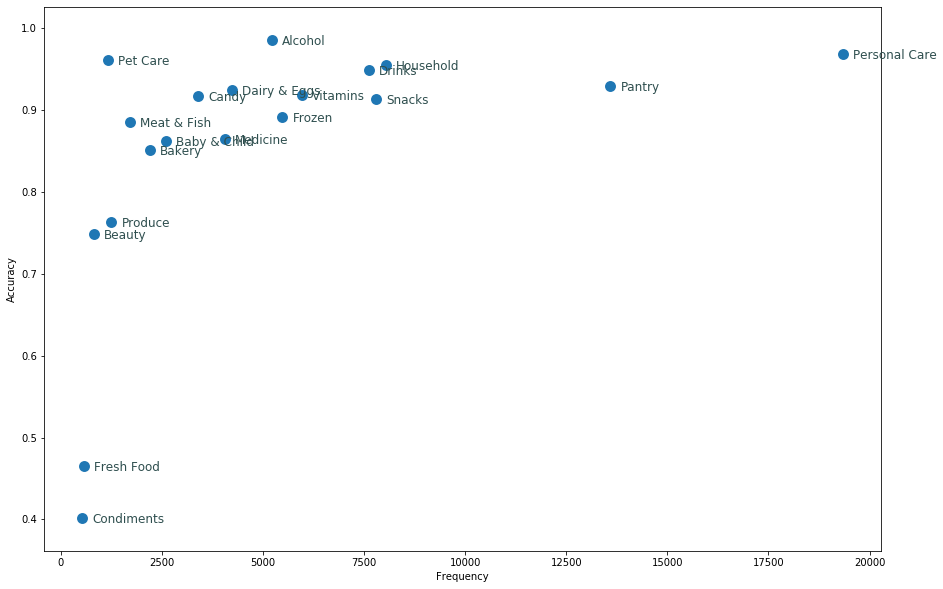

In [264]:
# Checkout how accuracy correlates with frequency
fig, ax = plt.subplots()
results.plot('Frequency', 'Accuracy', kind='scatter', ax=ax, s=120, linewidth=0, figsize=(15,10))

for k, v in results.iterrows():
    ax.annotate(k, v,
               xytext=(10,-5), textcoords='offset points',
               family='sans-serif', fontsize=12, color='darkslategrey')

In [239]:
# Understand the interaction between classes
confusion_matrix = pd.crosstab(targets, preds, margins=True)

# Set indexes to class names 
confusion_matrix.index = pd.Index(list(class_names) + ['All'], name="Actual")
confusion_matrix.columns = pd.Index(list(class_names) + ['All'], name="Predicted")

# Normalize confusion matrix 
normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)

confusion_matrix

Predicted,Alcohol,Drinks,Medicine,Personal Care,Baby & Child,Vitamins,Snacks,Bakery,Frozen,Pantry,Dairy & Eggs,Meat & Fish,Fresh Food,Household,Produce,Pet Care,Beauty,Candy,Condiments,All
Actual,,,,,,,,,,,,,,,,,,,,
Alcohol,1024,9,0,0,0,0,0,1,1,2,0,0,1,1,0,0,0,0,0,1039
Drinks,9,1474,1,1,2,16,1,1,4,31,7,1,0,2,4,0,0,0,0,1554
Medicine,0,3,687,27,23,43,0,0,0,2,0,0,0,7,0,0,1,1,0,794
Personal Care,1,4,40,3794,19,14,1,0,0,5,0,1,0,22,0,0,17,0,0,3918
Baby & Child,1,4,13,12,451,5,3,1,0,2,4,0,0,23,1,1,1,1,0,523
Vitamins,1,16,36,11,2,1046,5,0,1,9,1,1,0,3,2,0,1,3,0,1138
Snacks,2,5,0,1,0,0,1384,12,13,70,5,5,4,3,3,0,0,5,2,1514
Bakery,0,2,0,0,0,0,21,402,20,15,3,0,0,6,2,0,0,1,0,472
Frozen,1,8,0,0,0,0,12,17,973,31,7,13,7,6,10,0,0,5,1,1091


Text(159.0, 0.5, 'Actual labels')

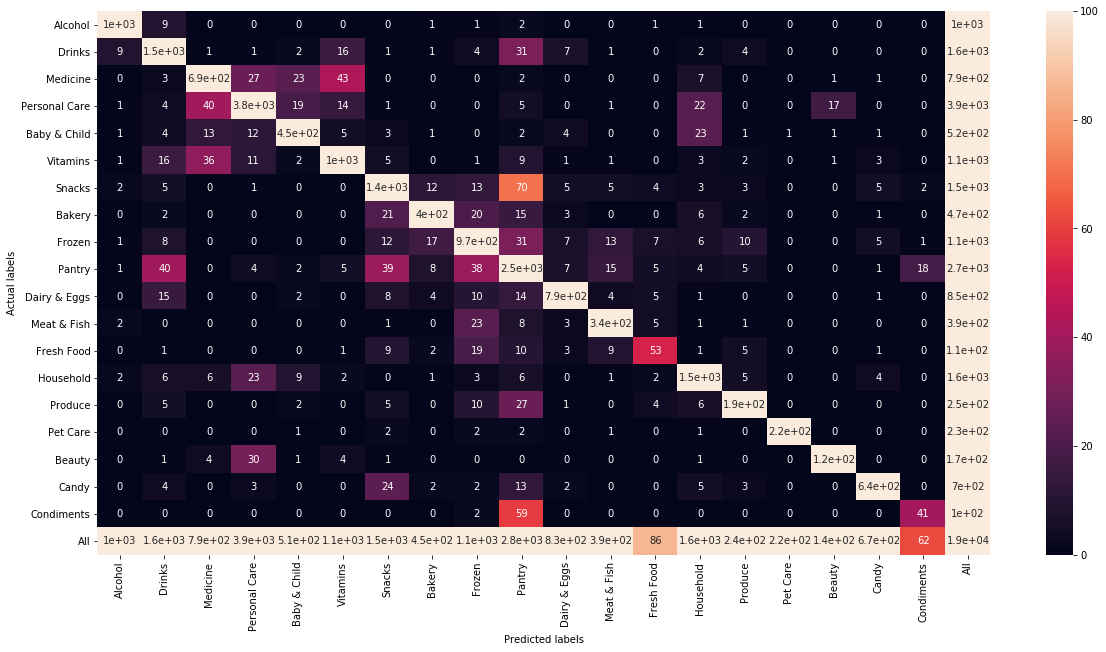

In [249]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(confusion_matrix, annot=True, ax=ax, vmin=0, vmax=100);

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels') 

In [139]:
# Category specific classifiers
def create_L2_dataset(l1):
    l2_dataset = df[df.l1 == l1]
    l2_dataset['l2_target'] = l2_dataset['l2']
    
df[df.l1 == 'Fresh Food']

,item_name,l1,l2,l1_target
4187,First Street Natural Party Tray Cheese (32 oz),Fresh Food,Trays,12
9113,ACE Sushi Seaweed Salad (4 oz),Fresh Food,Salad & Soup,12
9114,Apio Salad Shake Ups Avocado Ranch (5 oz),Fresh Food,Salad & Soup,12
9115,Eat Smart Sunflower Kale Vegetable Salad Kit (...,Fresh Food,Salad & Soup,12
9116,Mann's Nourish Bowls Southwest Chipotle (10.5 oz),Fresh Food,Salad & Soup,12
...,...,...,...,...
94417,Tyson Chicken Wings - Roasted (5 piece),Fresh Food,Wings,12
94450,Heinz Ranch Dipping Sauce (2 oz),Fresh Food,Wings,12
94482,Tyson Chicken Wing - Spicy (5 piece),Fresh Food,Wings,12
94511,Breaded Boneless Wings (8 ct),Fresh Food,Wings,12


In [253]:
dts = [x for x in df.groupby('l1')]

In [263]:
dts[0][1]

,item_name,l1,l2,l1_target
0,E & J Brandy Apple (750 ml),Alcohol,Liquor,0
1,Fairbanks Cream Sherry California (1.5 L),Alcohol,Liquor,0
2,Augustine Brandy Premium (1.75 l),Alcohol,Liquor,0
3,E & J Brandy VS Original (750 ml),Alcohol,Liquor,0
4,E&J VSOP Brandy (1.75lt),Alcohol,Liquor,0
...,...,...,...,...
94340,Cupcake Italy Sparkling Red Wine (750 ml),Alcohol,Wine,0
94341,M Touton Monsieur Touton 2018 Bordeaux Sauvign...,Alcohol,Wine,0
94342,Colores Del Sol Argentina Mendoza Malbec (750 ml),Alcohol,Wine,0
94343,Veuve Du Vernay Brut Rose Sparkling Wine (750 ml),Alcohol,Wine,0


In [23]:
# read full data
df = pd.read_csv('../data/processed/doordash.csv')
df.head()

,Name,L1,L2,L1_target,L2_target
0,E & J Brandy Apple (750 ml),Alcohol,Liquor,0,0
1,Fairbanks Cream Sherry California (1.5 L),Alcohol,Liquor,0,0
2,Augustine Brandy Premium (1.75 l),Alcohol,Liquor,0,0
3,E & J Brandy VS Original (750 ml),Alcohol,Liquor,0,0
4,E&J VSOP Brandy (1.75lt),Alcohol,Liquor,0,0


In [39]:
x = df[df["L1"] == "Personal Care"]["L2"].value_counts()
list(x[x <= 1].index)

['Sun care']

In [58]:
x = df.groupby(["L1", "L2"]).size()
y = x[x <= 1]
list(y.index)

[('Fresh Food', 'Health'),
 ('Household', 'Dog Treats & Toys'),
 ('Household', 'Liquor'),
 ('Meat & Fish', 'Lamb'),
 ('Personal Care', 'Sun care'),
 ('Produce', 'Canned Specialty'),
 ('Vitamins', 'Liquor')]

In [63]:
df[(df["L1"] == 'Fresh Food') & (df["L2"] == "Health")].index

Int64Index([], dtype='int64')

In [62]:
df = df.drop([50206])